In [23]:
%matplotlib ipympl
import numpy as np
from numpy.fft import  ifft2, ifftshift
#from scipy.special import kv as beselk
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets
#from ows import ows

## PSD
Power spectrum density

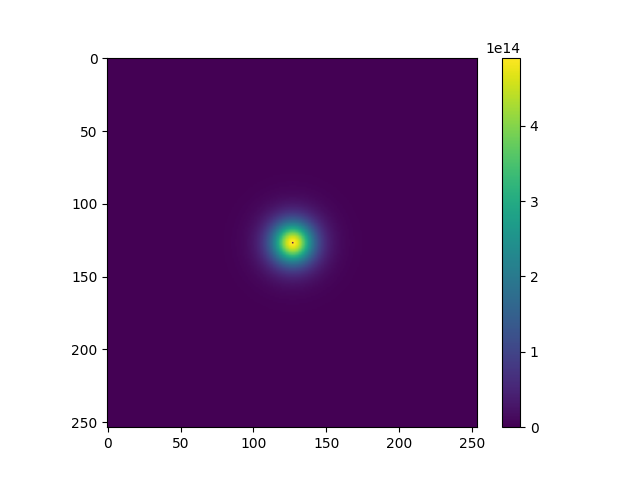

In [24]:


def psdtemp(N, r0, delta, l0, L0 = -1):
    """
    Generates a Phase power spectrum (PSD).

    Parameters:
    N (int): Size of the phase screen matrix (must be even).
    dx (float): Pixel size in meters.
    r0 (float): Fried's parameter at 500 nm.
    lo (float): Inner scale of turbulence.
    L0 (float): Outer scale of turbulence (set to -1 for infinite scale).
    seed (int, optional): Seed for random number generation.

    Returns:
    PSD (ndarray): 2D array representing the generated phase screen.
    """    


    # 2025.03.14 - Original version based on paola.pro (22.12.2022) by Laurent Jolissaint (HES-SO), lines 3659+
    # Not sure where all the coefficients come from
    #TODO: Make it work with L0 != -1
    #TODO: Change inherited variable names to something more meaningful
    

    # seed = 1
    # R = np.random.default_rng(seed)

    # del_f = 1/(N*delta)
    # fx = np.arange(-N/2., N/2.) * del_f

    # (fx, fy) = np.meshgrid(fx,fx)
    # f = np.sqrt(fx**2. + fy**2.)

    # fm = 5.92/l0/(2*np.pi)
    # f0 = 1./L0

    # PSD_phi = (0.023*r0**(-5./3.) * np.exp(-1*((f/fm)**2)) / (((f**2) + (f0**2))**(11./6)))

    # PSD_phi[int(N/2), int(N/2)] = 0

    # cn = ((R.normal(size=(N, N))+1j * R.normal(size=(N, N))) * np.sqrt(PSD_phi)*del_f)

    # phs = ift2(cn, 1).real

    # DFP       Pupil plane spatial frequency pixel size
    
    # Prepare the x direction coordinate matrix
    del_f = 1/(N*delta)
    fm = 5.92/l0/(2*np.pi)
    f0 = 1./L0
    
    #fx = np.arange(-N/2., N/2.) * del_f
    fx = np.linspace(-N/2,N/2-1,N)* del_f
    fpcoohfx, fpcoohfy = np.meshgrid(fx,fx) # Since it will be computed anyways, fpcoohfy will be used instead of rotating the xmatrix.
    # Prepare the radius matrix
    xpcoohf = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            xpcoohf[i][j]= np.sqrt(fpcoohfx[i][j]**2 + fpcoohfy[i][j]**2)  # pupil plane coordianate radius

    # Von Karman corrected PSD (L0 != -1) PAOLA:3666
    #Watm = np.zeros((N,N), dtype=np.double)
    if L0 == -1:
        w = np.where(fpcoohfx[0]**2+fpcoohfy[0]**2 > 0)
        dphi = 6.883877*(xpcoohf[w]/r0)**(5/3)
        Watm = 0.022896/(r0**(5/3))*np.sqrt(fpcoohfx**2+fpcoohfy**2)**(-11/3)
    else:
        w = np.where(xpcoohf != 0)
        dphi = 0.171661*(L0/r0)**(5/3)*((1.005635)-(2*np.pi*xpcoohf[w]/L0))**(5/6)
                               #beselk(5/6,2*np.pi*xpcoohf/L0)
        #Original line:
        # if w[0] ne -1 then dphi[w] = 0.171661d*(double(L0)/r0LAM)^(5.d/3)*((1.005635d)-(2*!dpi*xpcoohf[w]/double(L0))^(5.d/6)*$beselk(2*!dpi*xpcoohf[w]/double(L0),5.d/6))
        Watm = 0.022896/(r0**(5/3))*(fpcoohfx**2+fpcoohfy**2 +1/(L0**2))**(-11/3)

    PSD = Watm#*dphi
    PSD[int(N/2), int(N/2)] = 0
    return PSD

rad2asec = 3600 * 180/np.pi
asec2rad = 1/rad2asec

N = 254  # Matrix size
r0 = .1
L0 = 100
l0 = .1

delta = 10
#delta = asec2rad*60/N
PSD = psdtemp(N, r0, delta,l0, L0)

plt.close(0)
plt.figure(0)
plt.imshow((PSD))
plt.title("")
plt.colorbar()
plt.show()

## Phase screen

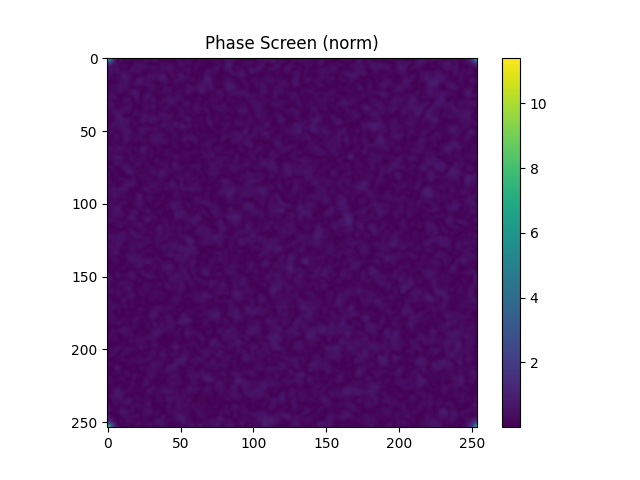

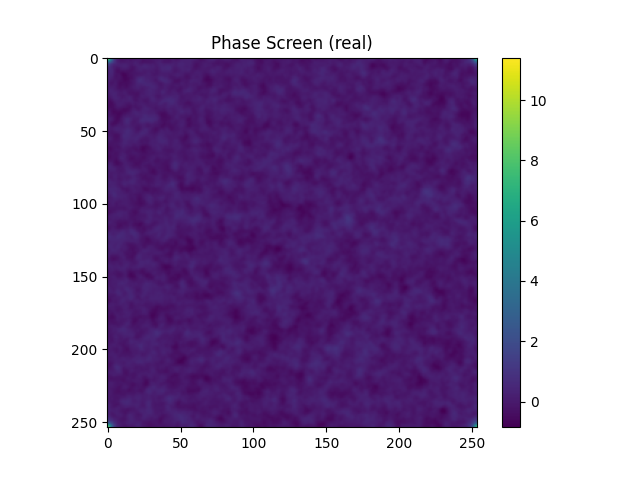

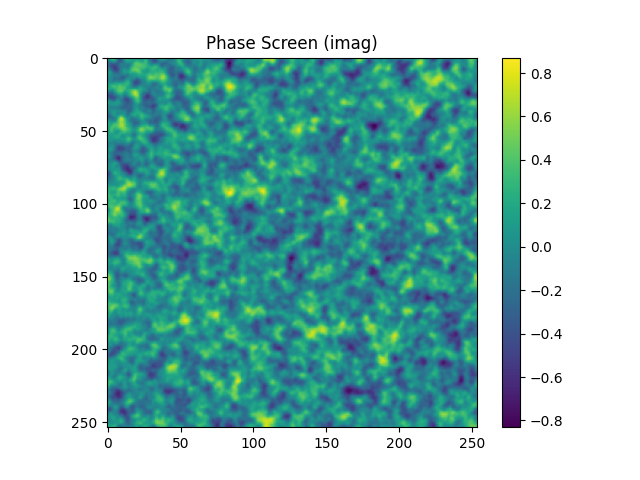

In [29]:
# Replace tmp1 and tmp2 to be more explicit
# They are currenty used in order to make it easier to compare with the original code
rad2asec = 3600 * 180/np.pi
asec2rad = 1/rad2asec

SEED = 1
FoV = 60 # arcsec
Npx = 540 # image plane pixels qty
Daf = 0.01#asec2rad*FoV/Npx # [rad/px]
WL = 500e-9 # [m]

DFP = Daf/WL # [m^-1/px] Pupil plane spatial frequency pixel size
DXP = 1/(DFP*N)

tmp2 = PSD*(N*DXP)**2 #original IDL translated
tmp2 = PSD*(N*DXP)**2
tmp2[0 : N, N-1] = tmp2[0 : N, 0] # last row = 1st row
tmp2[N-1, 0 : N] = tmp2[0, 0 : N] # last column = 1st column
tmp2[N-1, N-1] = tmp2[0, 0] # bottom right corner = top left corner

if SEED is not None:
  np.random.seed(SEED)
tmp2 = np.sqrt(tmp2)* np.random.rand(N, N)
tmp1 = np.sqrt(2)*(tmp2+np.rot90(tmp2,2))/2
tmp2 = np.random.rand(N,N)*2*np.pi
# in order to make sure that the phase is real,
# (1) the real part of the phase spectrum is forced to be even
# (2) the imaginary part of phase spectrum is forced to be odd
tmp2 =  (tmp1 * np.cos(0.5 * (tmp2 - np.rot90(tmp2)))) +1j*(tmp1 * np.sin(0.5 * (tmp2 - np.rot90(tmp2))))
phaseft = tmp2

#phaseft -= np.mean(phaseft) # remove piston?
phase_screen = ifft2(ifftshift(phaseft))

plt.close(1)
plt.figure(1)
plt.imshow(np.abs(phase_screen))
plt.title("Phase Screen (norm)")
plt.colorbar()
plt.show()

plt.close(2)
plt.figure(2)
plt.imshow(np.real(phase_screen))
plt.title("Phase Screen (real)")
plt.colorbar()
plt.show()

plt.close(3)
plt.figure(3)
plt.imshow(np.imag(phase_screen))
plt.title("Phase Screen (imag)")
plt.colorbar()
plt.show()


